In [ ]:
import os
import cv2
import numpy as np
import imutils
import random
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
arguments = {'dataset' : 'our_DATA/train and val','model' : 'covid19.model', 'plot' : 'plot.png' }

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
data_dir = "/content/drive/My Drive/our_DATA/"

Mounted at /content/drive/


In [1]:
INIT_LR = 1e-3
INIT_LR

0.001

In [ ]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [ ]:
imagePaths = list(paths.list_images(data_dir))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    # print(label)

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)

In [ ]:
data = np.array(data)
# data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
len(labels)

360

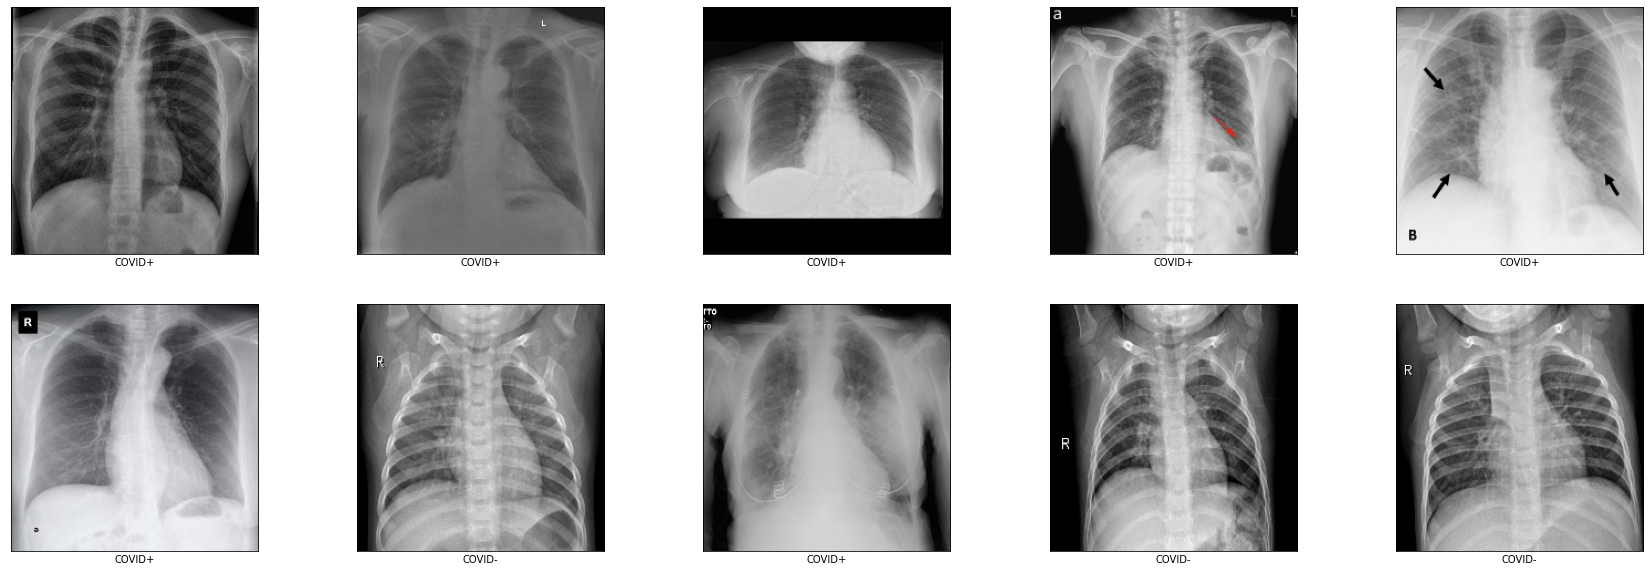

In [ ]:
def plot_sample_from_dataset(images, labels,rows=5, colums=5, width=8,height=8):
  plt.figure(figsize=(width,height))
  for i in range(rows*colums):
    plt.subplot(rows,colums,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = random.randint(0, len(labels)-1)
    plt.imshow(images[j], cmap=plt.cm.binary)
    plt.xlabel(labels[j])
  plt.show()

plot_sample_from_dataset(data, labels,rows=2, colums=5, width=30,height=10)

In [ ]:
print("before binarizer")
print(labels[:5],'\n')
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("after binarizer")
print(labels[:5],'\n')
labels = to_categorical(labels)
print("after one hot encoding")
print(labels[:5])

before binarizer
['COVID-' 'COVID-' 'COVID-' 'COVID-' 'COVID-'] 

after binarizer
[[1]
 [1]
 [1]
 [1]
 [1]] 

after one hot encoding
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
classes_names = lb.classes_
classes_number = len(lb.classes_)
print("number of classes : ",classes_number)
print("classes are : ",classes_names)

number of classes :  2
classes are :  ['COVID+' 'COVID-']


In [ ]:
from PIL import Image
import pandas as pd
def get_data_distribution(IMAGE_DIRECTORY, output_file=None,plot_stats=True):
    stats=[]

    #get all image directories
    directoriesz = next(os.walk(IMAGE_DIRECTORY))[1]
    # print(directoriesz)

    for diretcory_namez in directoriesz:
      directories = next(os.walk(os.path.join(IMAGE_DIRECTORY, diretcory_namez)))[1]
      # print(directories)
      for diretcory_name in directories:
          print("Loading {0}".format(diretcory_name))
          images_file_names = next(os.walk(os.path.join(IMAGE_DIRECTORY, diretcory_namez, diretcory_name)))[2]
          print("we will load [", len(images_file_names), "] files from [",diretcory_name,"] class, from folder [",diretcory_namez,"]..." )
          for i in range(len(images_file_names)):
            image_name = images_file_names[i]
            image_path = os.path.join(IMAGE_DIRECTORY, diretcory_namez, diretcory_name, image_name)
            #print(image_path)

            #the class is assumed to be equal to the directorty name
            label = diretcory_name 

            img = Image.open(image_path)
            #convert any image to RGB to make sure that it has three channels
            rgbimg = Image.new("RGB", img.size)
            rgbimg.paste(img)
            img=rgbimg
            
            #get the width and the height of the image in pixels
            width,height = img.size
            #get the size of the image in KB
            size_kb=os.stat(image_path).st_size/1000
            #add the size to a list of sizes to be 
            stats.append([label,os.path.basename(image_name),width,height,size_kb])

    if (output_file is not None):
      #convert the list into a dataframe to make it easy to save into a CSV
      stats_dataframe = pd.DataFrame(stats,columns=['Class','Filename','Width','Height','Size_in_KB'])
      stats_dataframe.to_csv(output_file,index=False)
      print("Stats collected and saved in .",output_file)
    else:
      print("Stats collected");

    return stats

stats = get_data_distribution(data_dir, output_file='info.csv',plot_stats=True)

Loading COVID-
we will load [ 125 ] files from [ COVID- ] class, from folder [ train ]...
Loading COVID+
we will load [ 125 ] files from [ COVID+ ] class, from folder [ train ]...
Loading COVID+
we will load [ 55 ] files from [ COVID+ ] class, from folder [ val ]...
Loading COVID-
we will load [ 55 ] files from [ COVID- ] class, from folder [ val ]...
Stats collected and saved in . info.csv


In [ ]:
statss = pd.read_csv("info.csv",index_col=[0])

In [ ]:
print(statss.head(20))

                 Filename  Width  Height  Size_in_KB
Class                                               
COVID-  IM-0127-0001.jpeg   1974    1306     669.289
COVID-  IM-0128-0001.jpeg   1528    1013     400.647
COVID-  IM-0117-0001.jpeg   1422    1152     406.305
COVID-  IM-0115-0001.jpeg   2090    1858     870.784
COVID-  IM-0119-0001.jpeg   1810    1434     582.639
COVID-  IM-0140-0001.jpeg   1156    1237     500.621
COVID-  IM-0187-0001.jpeg   1854    1572     716.369
COVID-  IM-0164-0001.jpeg   1202     808     259.534
COVID-  IM-0131-0001.jpeg   1450    1144     458.085
COVID-  IM-0160-0001.jpeg   1750    1314     600.582
COVID-  IM-0129-0001.jpeg   1384    1167     420.270
COVID-  IM-0154-0001.jpeg   1844    1438     593.087
COVID-  IM-0162-0001.jpeg   1762    1430     682.625
COVID-  IM-0182-0001.jpeg   1372    1005     352.757
COVID-  IM-0133-0001.jpeg   1468     993     384.933
COVID-  IM-0158-0001.jpeg    994     758     214.302
COVID-  IM-0180-0001.jpeg   2136    1650     9

In [ ]:
statss['Width'].mean(0)

1473.6416666666667

In [ ]:
statss['Height'].mean(0)

1276.8222222222223

2  classes found in the dataset
Images of the whole dataset have an average  Size_in_KB  of  470.6630305555554
sizes of class [ COVID- ] have an average  Size_in_KB  of  558.4422611111112
sizes of class [ COVID+ ] have an average  Size_in_KB  of  382.88379999999995


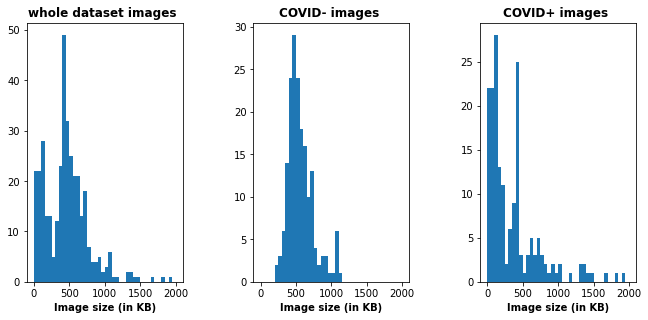

In [ ]:
import math
def plot_dataset_distribution (stats, target='Size_in_KB', num_cols=5, width=10, height=5, histogram_bins = 10, histogram_range=[0, 1000], figure_padding=4):
  #convert the list into a dataframe
  stats_frame = pd.DataFrame(stats,columns=['Class','Filename','Width','Height','Size_in_KB'])

  #extract the datframe related to sizes only
  list_sizes=stats_frame[target]

  #get the number of classes in the dataset
  number_of_classes=stats_frame['Class'].nunique()
  print(number_of_classes, " classes found in the dataset")

  #create a list of (list of sizes) for each class of images
  #we start by the the sizes of all images in the dataset
  list_sizes_per_class=[list_sizes] 
  class_names=['whole dataset']
  print("Images of the whole dataset have an average " ,target, " of ", list_sizes.mean())
  
  for c in stats_frame['Class'].unique():
    print("sizes of class [", c, "] have an average " ,target, " of ", list_sizes.loc[stats_frame['Class']== c].mean())
    #then, we append the sizes of images of a particular class
    list_sizes_per_class.append(list_sizes.loc[stats_frame['Class'] == c])
    class_names.append(c)

  num_rows=math.ceil((number_of_classes+1)/num_cols)
  if (number_of_classes<num_cols):
    num_cols=number_of_classes+1
  fig,axes = plt.subplots(num_rows, num_cols, figsize=(width,height))
    

  fig.tight_layout(pad=figure_padding)
  class_count=0
  if (num_rows==1 or num_cols==1):
    for i in range(num_rows):
      for j in range(num_cols): 
        axes[j+i].hist(list_sizes_per_class[num_cols*i+j], bins = histogram_bins, range=histogram_range)
        axes[j+i].set_xlabel('Image size (in KB)', fontweight='bold')
        axes[i+j].set_title(class_names[j+i] + ' images ', fontweight='bold')
        class_count=class_count+1
        if (class_count==number_of_classes+1):
          break
  
  else:
    for i in range(num_rows):
      for j in range(num_cols): 
        axes[i,j].hist(list_sizes_per_class[num_cols*i+j], bins = histogram_bins, range=histogram_range)
        axes[i,j].set_xlabel('Image size (in KB)', fontweight='bold')
        axes[i,j].set_title(class_names[i] + ' images ', fontweight='bold')
        class_count=class_count+1
        if (class_count==number_of_classes+1):
          break
plot_dataset_distribution (stats, target='Size_in_KB', num_cols=5, width=10, height=5, histogram_bins = 40, histogram_range=[0, 2000], figure_padding=4)

2  classes found in the dataset
Images of the whole dataset have an average  Height  of  1276.8222222222223
sizes of class [ COVID- ] have an average  Height  of  1315.7277777777779
sizes of class [ COVID+ ] have an average  Height  of  1237.9166666666667


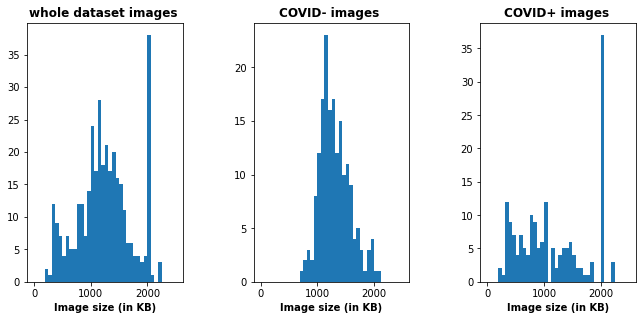

In [ ]:
plot_dataset_distribution (stats, target='Height', num_cols=5, width=10, height=5, histogram_bins = 40, histogram_range=[0, 2500], figure_padding=4)

2  classes found in the dataset
Images of the whole dataset have an average  Width  of  1473.6416666666667
sizes of class [ COVID- ] have an average  Width  of  1650.4
sizes of class [ COVID+ ] have an average  Width  of  1296.8833333333334


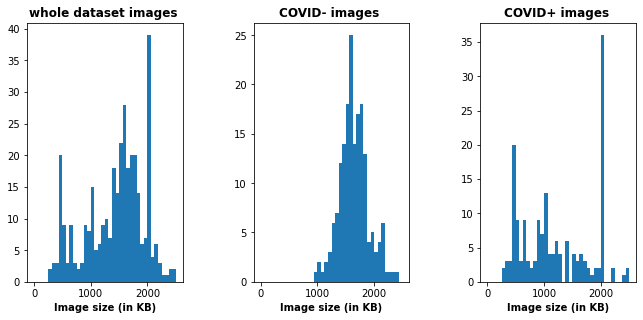

In [ ]:
plot_dataset_distribution (stats, target='Width', num_cols=5, width=10, height=5, histogram_bins = 40, histogram_range=[0, 2500], figure_padding=4)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [ ]:
baseModel = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

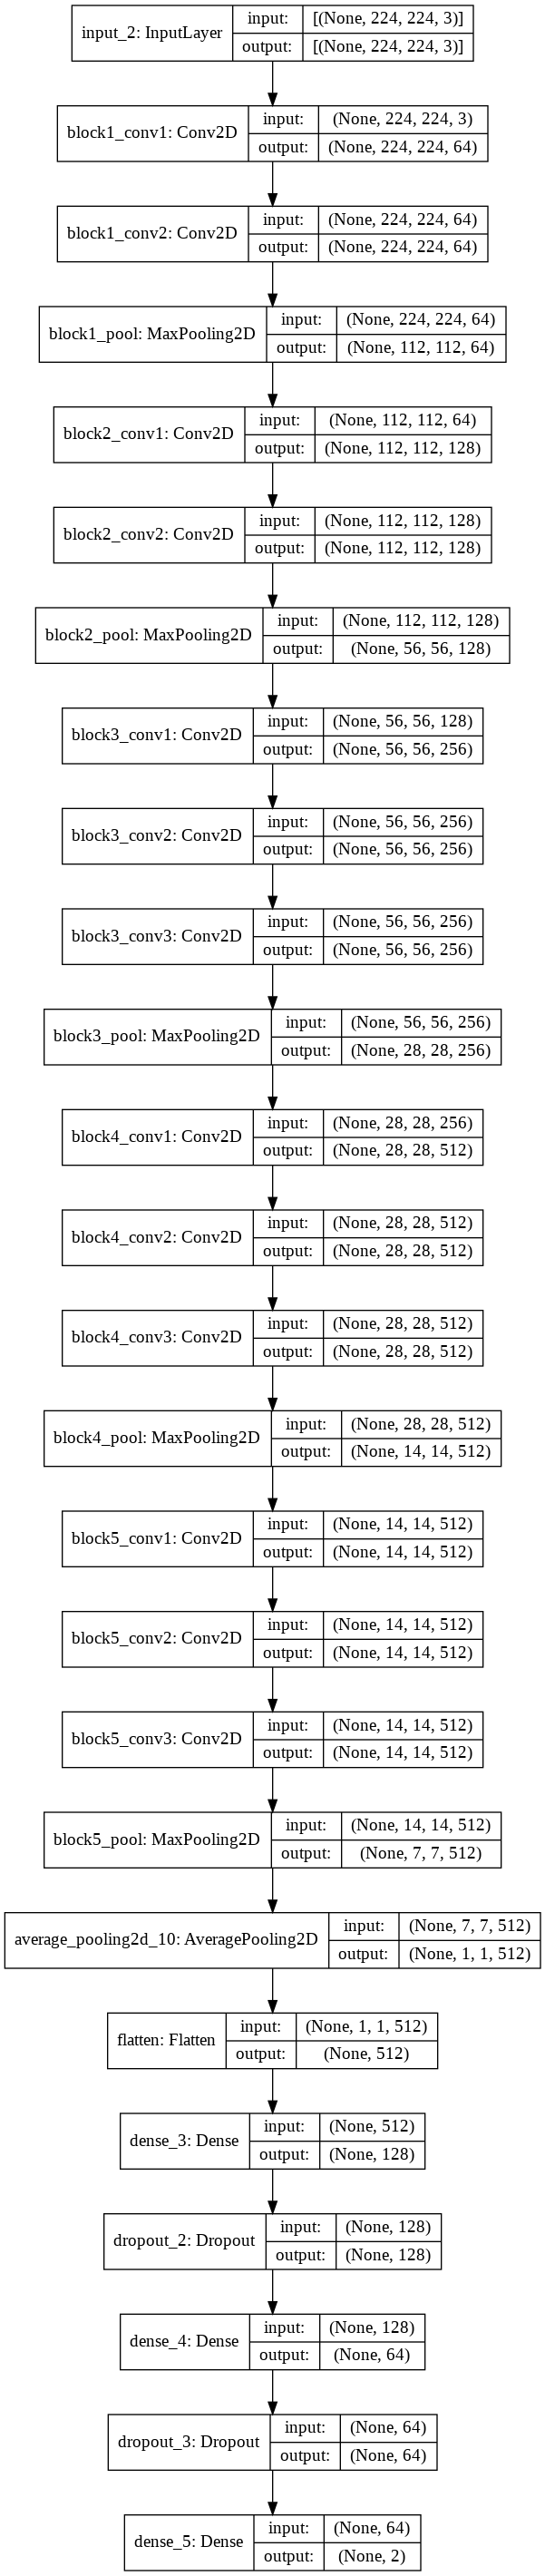

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=INIT_LR), metrics=["accuracy"])

In [ ]:
# train the head of the network
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/10
36/36 [==============================] - 12s 112ms/step - loss: 2.6138 - accuracy: 0.6241 - val_loss: 0.1309 - val_accuracy: 0.9583
Epoch 2/10
36/36 [==============================] - 4s 100ms/step - loss: 0.4747 - accuracy: 0.8858 - val_loss: 0.0874 - val_accuracy: 0.9722
Epoch 3/10
36/36 [==============================] - 4s 98ms/step - loss: 0.3173 - accuracy: 0.8939 - val_loss: 0.0614 - val_accuracy: 0.9722
Epoch 4/10
36/36 [==============================] - 4s 99ms/step - loss: 0.1165 - accuracy: 0.9559 - val_loss: 0.0226 - val_accuracy: 0.9861
Epoch 5/10
36/36 [==============================] - 4s 99ms/step - loss: 0.0894 - accuracy: 0.9755 - val_loss: 0.0235 - val_accuracy: 0.9861
Epoch 6/10
36/36 [==============================] - 4s 100ms/step - loss: 0.1801 - accuracy: 0.9547 - val_loss: 0.0191 - val_accuracy: 0.9861
Epoch 7/10
36/36 [==============================] - 4s 98ms/step - loss: 0.0622 - accuracy: 0.9794 - val_loss: 0.0261 - val_accuracy: 0.9861
Epoch 8/1

In [ ]:
predictions = model.predict(testX, batch_size=BS)
predictions = np.argmax(predictions, axis=1)

print(classification_report(testY.argmax(axis=1), predictions,target_names=lb.classes_))

              precision    recall  f1-score   support

      COVID+       1.00      0.93      0.96        29
      COVID-       0.96      1.00      0.98        43

    accuracy                           0.97        72
   macro avg       0.98      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



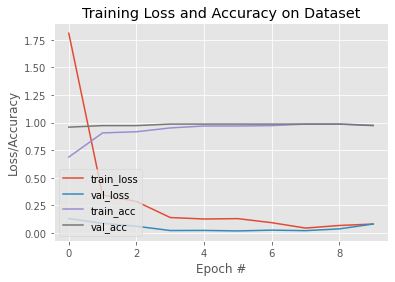

In [ ]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(arguments["plot"])

In [ ]:
model.save(arguments["model"], save_format="h5")

In [ ]:
# saved_model_path = arguments["model"]
# model.save(saved_model_path)

In [ ]:
import pickle
f = open("simple_nn_lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
from google.colab import files
# files.download("plot.png")

In [ ]:
model = load_model("covid19.model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7xld1xj1/assets


Probability Positive: 0.00
Probability Negative: 100.00


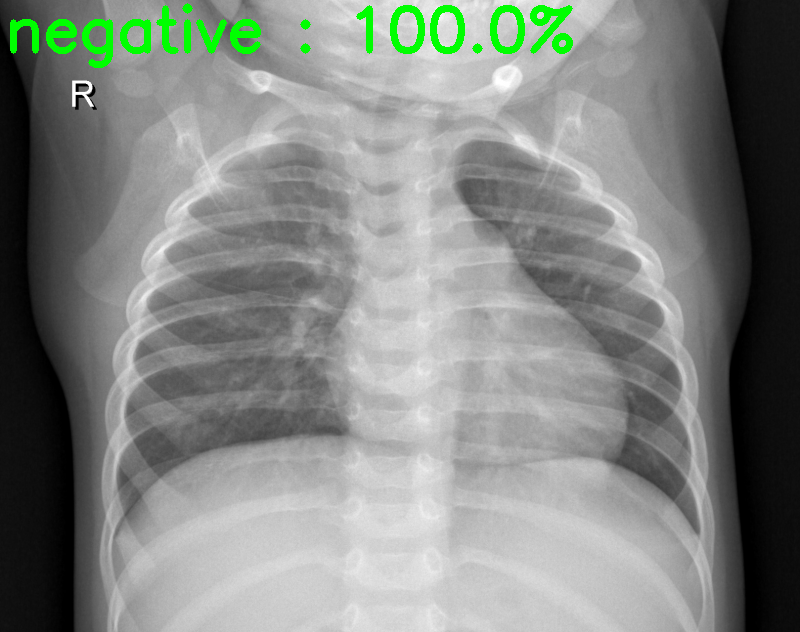

In [ ]:
from google.colab.patches import cv2_imshow

model = load_model("covid19.model")

image = cv2.imread("/content/drive/MyDrive/our_DATA/val/COVID+/1-s2.0-S0140673620303706-fx1_lrg.jpg")
image = cv2.imread("/content/drive/MyDrive/our_DATA/val/COVID+/88de9d8c39e946abd495b37cd07d89e5-2ee6-0.jpg")
image = cv2.imread("/content/drive/MyDrive/our_DATA/val/COVID-/IM-0122-0001.jpeg")
image2 = image.copy()
image2 = imutils.resize(image2 , width=800)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = np.reshape(image, (1,224,224,3))

pred = model.predict(image)
prob_positive = pred[0][0] * 100;
prob_negative = pred[0][1] * 100;
print("Probability Positive: %.2f" %  prob_positive)
print("Probability Negative: %.2f" %  prob_negative)

if (prob_positive > prob_negative):
    cv2.putText(image2,"positive : "+str(round(prob_positive, 2))+"%",(5, 50),cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 5)
else:
    cv2.putText(image2,"negative : "+str(round(prob_negative, 2))+"%",(5, 50),cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)


cv2_imshow(image2)

In [ ]:
image = cv2.imread("/content/drive/MyDrive/our_DATA/val/COVID+/1-s2.0-S0140673620303706-fx1_lrg.jpg")
image = cv2.imread("/content/drive/MyDrive/our_DATA/val/COVID+/88de9d8c39e946abd495b37cd07d89e5-2ee6-0.jpg")
image = cv2.imread("/content/drive/MyDrive/our_DATA/val/COVID-/IM-0122-0001.jpeg")
image = cv2.resize(image, (224,224))
image = np.array(image, dtype="float32")
image = np.reshape(image, (1,224,224,3))

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

print("*"*50, input_details)
interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

************************************************** [{'name': 'input_2', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[2.3410657e-20 1.0000000e+00]]
